In [1]:
from hcp_class import hcp_subj
import numpy as np
from functools import reduce
import nibabel as nib
import pickle
import sys
import seaborn as sn
import subprocess as sp
import os
from utils import save_gifti
from nilearn.plotting import view_surf
from statistics import mode

In [3]:
cpus

24

In [4]:
subjects=!cat text_files/SubjectsWithCorrectGradOrientaiton.txt

In [5]:
def check_gradOrientation(ID):
    subj=hcp_subj(ID,4)
    
    if subj.Lgrad[1] ==True and subj.Rgrad[1] == True:
        return 1
    else:
        return 0 

In [6]:
len(subjects)

999

In [ ]:
from multiprocessing.pool import Pool as ProcessPool
import multiprocessing
import time
cpus=multiprocessing.cpu_count()

In [7]:
with ProcessPool(processes=cpus-1) as pool:  # context manager providing a Pool instance
    Orientation=pool.map(check_gradOrientation,subjects)
Orientation=np.asarray(Orientation)
CleanSubjects=np.where(Orientation==1)[0]
subjects=[subjects[i] for i in CleanSubjects]

In [12]:
list(map(check_gradOrientation,subjects))

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [6]:
def loadDistance70to99(ID):
    """Load the multiple threshold distance maps"""
    subj=hcp_subj(ID,4)
    Ldist=np.load(f'/well/margulies/projects/pkReliability/Dist2SensoryBorder/{ID}/L.70to99Thr.npy')    
    Rdist=np.load(f'/well/margulies/projects/pkReliability/Dist2SensoryBorder/{ID}/R.70to99Thr.npy')
    return Ldist,Rdist
def loadAreaFactor(ID):
    subj=hcp_subj(ID,4)
    Larea=nib.load(f'/well/margulies/projects/pkReliability/AreaMetrics/{ID}.L.area.func.gii').darrays[0].data
    Larea=np.sqrt(np.sum(Larea[subj.Lfill]))
    Rarea=nib.load(f'/well/margulies/projects/pkReliability/AreaMetrics/{ID}.R.area.func.gii').darrays[0].data
    Rarea=np.sqrt(np.sum(Rarea[subj.Rfill]))
    return Larea,Rarea

In [7]:
### the range corresponding to thresholds for of each index in each subjects distance arrays
Thrs=np.asanyarray(list(range(70,100)))

In [8]:
%time
with ProcessPool(processes=cpus-1) as pool:  # context manager providing a Pool instance
    distArrays=pool.map(loadDistance70to99,subjects)
    areas=pool.map(loadAreaFactor,subjects)
LdistArrays=dict(zip(subjects,[x[0] for x in distArrays]))
RdistArrays=dict(zip(subjects,[x[1] for x in distArrays]))
Lareas=dict(zip(subjects,[x[0] for x in areas]))
Rareas=dict(zip(subjects,[x[1] for x in areas]))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.58 µs


In [9]:
def getSensory(label):
    data=nib.load(label).darrays[0].data
    
    A1=np.hstack([np.where(data==33)[0],np.where(data==75)[0]])
    S1=np.hstack([np.where(data==28)[0],np.where(data==46)[0]])
    V1=np.hstack([np.where(data==45)[0]])#,np.where(data==43)[0] ####exclude the occipital pole
    return A1,V1,S1

In [10]:
def SensVals(subj,distArr,hemi):
    data=np.round(distArr)
    if hemi == 'L':
        A1,V1,S1=getSensory(subj.Laparc)      
    elif hemi =='R':
        A1,V1,S1=getSensory(subj.Raparc)
   
    A1Vals=data[A1]
    S1Vals=data[S1]
    V1Vals=data[V1]
    

    equi=reduce(np.intersect1d,[A1Vals,S1Vals,V1Vals])
    distVals=np.hstack([A1Vals,S1Vals,V1Vals])

    if equi.shape[0] <1:
#         print(f'subject {subj.subj} has no equidistant value from gradient mask to the {hemi} sensory cortex')
        val = 0
        lowest=0
        highest=0
        common=0
        valid=0
        max_dist=np.max(data)
        return [lowest,highest,common,max_dist,valid]
    else:
        equi=list(equi)
        val=[np.count_nonzero(distVals==val) for val in equi ]
        valid=1

        common=equi[np.argmax(val)]
        highest=np.max(equi)
        lowest=np.min(equi)
        max_dist=np.max(data)
#             print(f'the common is {common},max is {highest},min is {lowest}, median ins {np.round(med)}')
        return [lowest,highest,common,max_dist,valid]

In [12]:
def checkMedial(subj,thr,hemi):
    grad=subj.extract_topX(subj.Lgrad,subj.Rgrad,thr)
    ### choose watershed hemi###
    if hemi =='L':
        WS=nib.load('watershed_templates/LWS.28.max.label.gii').darrays[0].data
        grad=grad[0]
    elif hemi =='R':
        WS=nib.load('watershed_templates/RWS.28.max.label.gii').darrays[0].data
        grad=grad[1]
    ### get ROI to intersect with grad thresh 
    mpar=np.where(WS==7)[0]
    mtmp=np.where(WS==8)[0]
    occ=np.where(WS==9)[0]
    
    mpar=np.intersect1d(grad,mpar).shape[0]
    mtmp=np.intersect1d(grad,mtmp).shape[0]
    occ=np.intersect1d(grad,occ).shape[0]
    if mpar>0:
        mpar=1
    else:
        mpar=0
    if mtmp>0:
        mtmp=1
    else:
        mtmp=0
    if occ>0:
        occ=0
    else:
        occ=1
    return [mpar,mtmp,occ]

In [13]:
def get_valsMultiThr(ID):
    subj=hcp_subj(ID,4)
    thrs=np.asanyarray(list(range(70,100)))
    Ldata=[]
    Rdata=[]
    for idx in range(len(thrs)):
        Lsens=SensVals(subj,LdistArrays[ID][idx],'L')
        Lmed=checkMedial(subj,thrs[idx],'L')
        L=Lsens+Lmed
        Ldata.append(L)
        
        
        Rsens=SensVals(subj,LdistArrays[ID][idx],'R')
        Rmed=checkMedial(subj,thrs[idx],'R')
        R=Rsens+Rmed
        Rdata.append(R)
    return dict(zip(thrs,Ldata)),dict(zip(thrs,Rdata))

In [14]:
########### Return order is 
# [lowest,highest,common,max_dist,valid,mpar,mtmp,occ]
##[  val,   val,       val,       bool, bool, bool,bool]

In [15]:
%time
with ProcessPool(processes=cpus-1) as pool:  # context manager providing a Pool instance
    Summary=pool.map(get_valsMultiThr,subjects)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 7.63 µs


In [16]:
Lsummary=dict(zip(subjects,[x[0] for x in Summary]))
Rsummary=dict(zip(subjects,[x[1] for x in Summary]))

In [17]:
import pandas as pd

In [18]:
########### Return order is 
# [lowest,highest,common,max_dist,valid,mpar,mtmp,occ]
##[  val,   val,       val,       bool, bool, bool]

In [19]:
def summaryStats(data,thresh):
    pct_valid=[]
    pct_mtmp=[]
    pct_mpar=[]
    pct_occ=[]
    equi=[]
    for thr in thresh:
        eq=0
        tmp=0
        par=0
        occ=0
        for key in data.keys():
            eq+=data[key][thr][4]
            tmp+=data[key][thr][6]
            par+=data[key][thr][5]
            occ+=data[key][thr][-1]
        equi.append(eq)
        pct_valid.append(eq/len(data))
        pct_mtmp.append(tmp/len(data))
        pct_mpar.append(par/len(data))
        pct_occ.append(1-(occ/len(data)))
    return equi,pct_valid,pct_mpar,pct_mtmp,pct_occ

In [20]:
L=summaryStats(Lsummary,Thrs)
R=summaryStats(Rsummary,Thrs)

In [21]:
!mkdir -p figures dec52022

In [23]:
import matplotlib.pyplot as plt

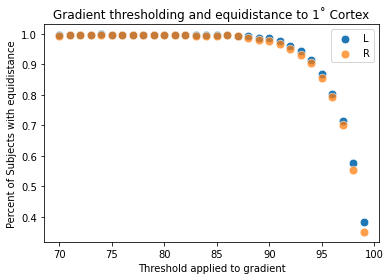

In [24]:
sn.scatterplot(x=Thrs,y=L[1],alpha=1,s=75,label='L')
sn.scatterplot(x=Thrs,y=R[1],alpha=0.75,s=75,label='R')
plt.title('Gradient thresholding and equidistance to 1˚ Cortex')
plt.xlabel('Threshold applied to gradient')
plt.ylabel('Percent of Subjects with equidistance')
plt.savefig('dec52022/EquiDistanceMaintenance_LR.png', dpi=300,facecolor='w')



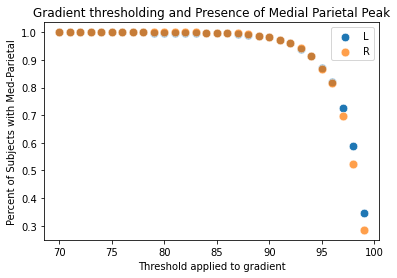

In [25]:
sn.scatterplot(x=Thrs,y=L[2],alpha=1,s=75,label='L')
sn.scatterplot(x=Thrs,y=R[2],alpha=0.75,s=75,label='R')
plt.title('Gradient thresholding and Presence of Medial Parietal Peak')
plt.xlabel('Threshold applied to gradient')
plt.ylabel('Percent of Subjects with Med-Parietal')
plt.savefig('dec52022/Parietal_LR.png', dpi=300,facecolor='w')

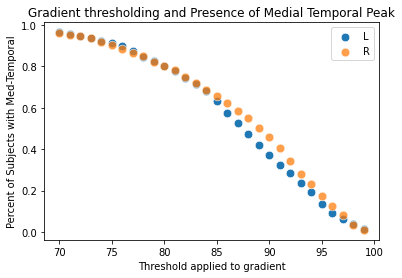

In [26]:
sn.scatterplot(x=Thrs,y=L[3],alpha=1,s=75,label='L')
sn.scatterplot(x=Thrs,y=R[3],alpha=0.75,s=75,label='R')
plt.title('Gradient thresholding and Presence of Medial Temporal Peak')
plt.xlabel('Threshold applied to gradient')
plt.ylabel('Percent of Subjects with Med-Temporal')
plt.savefig('dec52022/Med-Temporal_LR.png', dpi=300,facecolor='w')

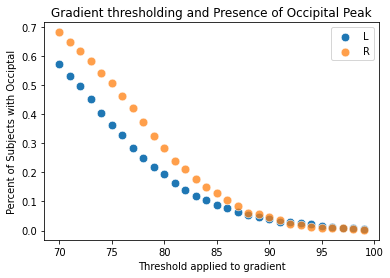

In [27]:
sn.scatterplot(x=Thrs,y=L[4],alpha=1,s=75,label='L')
sn.scatterplot(x=Thrs,y=R[4],alpha=0.75,s=75,label='R')
plt.title('Gradient thresholding and Presence of Occipital Peak')
plt.xlabel('Threshold applied to gradient')
plt.ylabel('Percent of Subjects with Occiptal')
plt.savefig('dec52022/Occipital_LR.png', dpi=300,facecolor='w')

In [28]:
import matplotlib.pyplot as plt

In [29]:
def returnPercentiles(summary,thresh):
    """takes input of the Lsummary and Rsummary dicts + a threshold """
#     EquiMax=[]
#     EquiMin=[]
#     GlobalMax=[]
    eq=0
    eqWpar=0
    eqWtmp=0
    eqNopar=0
    eqNotmp=0
    eqneither=0
    Par=0
    Tmp=0

    
    for key in summary.keys():
        
        data=summary[key][thresh]
        eq+=data[4]
        Par+=data[5]
        Tmp+=data[6]
        
        if data[4]==1 and data[5]==1:
            eqWpar+=1
        if data[6]==1 and data[6]==1:
            eqWtmp+=1
        elif data[4]==1 and data[5]==0:
            eqNopar+=1
        if data[4]==1 and data[6]==0:
            eqNotmp+=1
        if data[4]==1 and data[5]==0 and data[6]==0:
            eqneither+=1
        
    equiRatio=eq/len(summary) ### how many of our total subjects have equidistance
    ParPkEquiRatio=eqWpar/eq ### how many of the equidistant subjects have a parietal peak 
    TmpPkEquiRatio=eqWtmp/eq ### how many of the equidistant subjects have a parietal peak 
    NoParPkEquiRatio=eqNopar/eq ### how many of the equidistant don't care about the parietal 
    
    NoTmpPkEquiRatio=eqNotmp/eq ### how many equidistants don't care about the medial temporal pk
    NeitherPkEquiratio=eqneither/eq
    
    return eq,ParPkEquiRatio,TmpPkEquiRatio,NoParPkEquiRatio,NoTmpPkEquiRatio,NeitherPkEquiratio
    


In [30]:
Lratios=[]
Rratios=[]
for i in Thrs:
    Lratios.append(returnPercentiles(Lsummary,i))
    Rratios.append(returnPercentiles(Rsummary,i))

In [31]:
##inclusion
Leq=[x[0] for x in Lratios]
Lpar=[x[1] for x in Lratios]
Ltmp=[x[2] for x in Lratios]


Req=[x[0] for x in Rratios]
Rpar=[x[1] for x in Rratios]
Rtmp=[x[2] for x in Rratios]

#exclusion

LnoPar=[x[3] for x in Lratios]
LnoTmp=[x[4] for x in Lratios]
RnoPar=[x[3] for x in Rratios]
RnoTmp=[x[4] for x in Rratios]



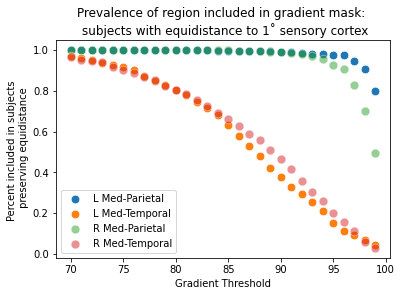

In [32]:
sn.scatterplot(x=Thrs,y=Lpar,label='L Med-Parietal',s=75,alpha=1)
sn.scatterplot(x=Thrs,y=Ltmp,label='L Med-Temporal',s=75,alpha=1)

sn.scatterplot(x=Thrs,y=Rpar,label='R Med-Parietal',s=75,alpha=0.5)
sn.scatterplot(x=Thrs,y=Rtmp,label='R Med-Temporal',s=75,alpha=0.5)

plt.title('Prevalence of region included in gradient mask: \n subjects with equidistance to 1˚ sensory cortex')
plt.xlabel('Gradient Threshold')
plt.ylabel('Percent included in subjects \n preserving equidistance')
plt.savefig('dec52022/regionInclusion.png', dpi=300,facecolor='w')
### how often the parietal peak is present in equidistant subjects vs how often the temporal is in equidistant subjects 

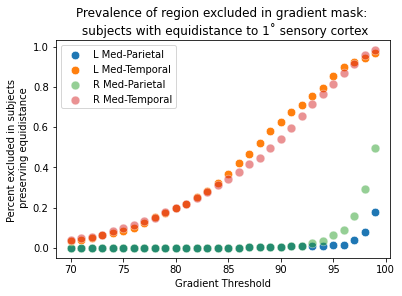

In [33]:
sn.scatterplot(x=Thrs,y=LnoPar,label='L Med-Parietal',s=75,alpha=1)
sn.scatterplot(x=Thrs,y=LnoTmp,label='L Med-Temporal',s=75,alpha=1)

sn.scatterplot(x=Thrs,y=RnoPar,label='R Med-Parietal',s=75,alpha=0.5)
sn.scatterplot(x=Thrs,y=RnoTmp,label='R Med-Temporal',s=75,alpha=0.5)

plt.title('Prevalence of region excluded in gradient mask: \n subjects with equidistance to 1˚ sensory cortex')
plt.xlabel('Gradient Threshold')
plt.ylabel('Percent excluded in subjects \n preserving equidistance')
plt.savefig('dec52022/regionExclusion.png', dpi=300,facecolor='w')
### how often the parietal peak is present in equidistant subjects vs how often the temporal is in equidistant subjects 

In [34]:
########### Return order is 
# [lowest,highest,common,max_dist,valid,mpar,mtmp,occ]
##[  val,   val,       val,       bool, bool, bool]

In [35]:
def returnValues(summary,thresh):
    """takes input of the Lsummary and Rsummary dicts + a threshold """
    EquiMin=[]
    EqMinNorm=[]
    
    EquiMax=[]
    EqMaxNorm=[]
    
    Common=[]
    CommonNorm=[]
    
    MaxTravelled=[]
    
    for key in summary.keys():
        data=summary[key][thresh]
        if data[4]==1:
            globalMax=data[3]
            EquiMin.append(data[0])
            EqMinNorm.append(data[0]/globalMax)
            
            EquiMax.append(data[1])
            EqMaxNorm.append(data[1]/globalMax)
            
            Common.append(data[2])
            CommonNorm.append(data[2]/globalMax)
            MaxTravelled.append(globalMax)
            
    
    return np.asarray(EquiMin),np.asarray(EqMinNorm),np.asarray(EquiMax),np.asarray(EqMaxNorm),np.asarray(Common), np.asarray(CommonNorm),np.asarray(MaxTravelled)

In [36]:
Lvalues=[]
Rvalues=[]
for i in Thrs:
    Lvalues.append(returnValues(Lsummary,i))
    Rvalues.append(returnValues(Rsummary,i))

In [37]:
def to_df(x,thrs):
    x=pd.DataFrame.from_dict(dict(zip(thrs,x)),orient='index')
    return x

In [38]:
def process_values(vals,thrs):
    mini=mini=[x[0] for x in vals]
    mini=to_df(mini,thrs).T
    
    miniNorm=[x[1] for x in vals]
    miniNorm=to_df(miniNorm,thrs).T
    
    maxi=[x[2] for x in vals]
    maxi=to_df(maxi,thrs).T
    
    maxiNorm=[x[3] for x in vals]
    maxiNorm=to_df(maxiNorm,thrs).T
    
    common=[x[4] for x in vals]
    common=to_df(common,thrs).T
    
    commonNorm=[x[5] for x in vals]
    commonNorm=to_df(commonNorm,thrs).T
    
    globalMax=[x[6] for x in vals]
    globalMax=to_df(globalMax,thrs).T
    
    
    return mini,miniNorm,maxi,maxiNorm,common,commonNorm,globalMax

In [39]:
Lmini,LminiN,Lmaxi,LmaxiN,Lcommon,LcommonN,Lg=process_values(Lvalues,Thrs)

Rmini,RminiN,Rmaxi,RmaxiN,Rcommon,RcommonN,Rg=process_values(Rvalues,Thrs)

In [40]:
def plot_df(Ldf,Rdf,title):
    fig=plt.figure(figsize=(14,6))
    plt.subplot(211)
    ax=sn.boxenplot(data=Ldf,palette='viridis')
    plt.title('Left Hemishpere')
    plt.ylabel('Distance')
    plt.subplot(212)
    ax=sn.boxenplot(data=Rdf,palette='viridis')
    plt.title('Right Hemishpere')
    plt.ylabel('Distance')
    plt.xlabel('Threshold')
    plt.suptitle(title)
    fig.tight_layout()
    
    return ax
    

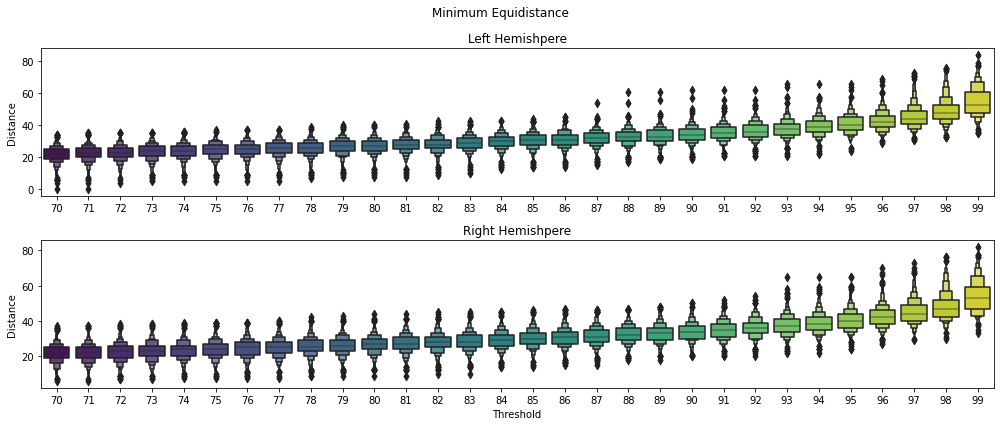

In [41]:
plot_df(Lmini,Rmini,'Minimum Equidistance')
plt.savefig('dec52022/MinimumDist.png',dpi=300,bbox_inches='tight',facecolor='w')

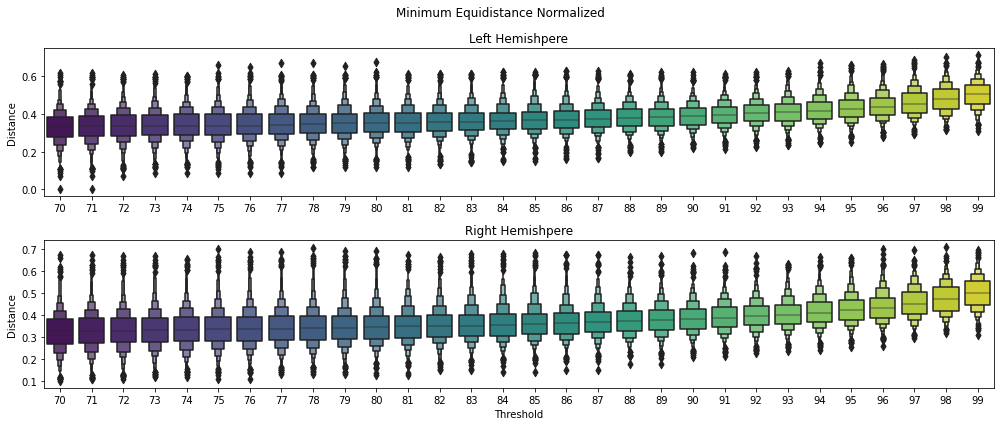

In [42]:
plot_df(LminiN,RminiN,'Minimum Equidistance Normalized')
plt.savefig('dec52022/MinimumDistNorm.png',dpi=300,bbox_inches='tight',facecolor='w')

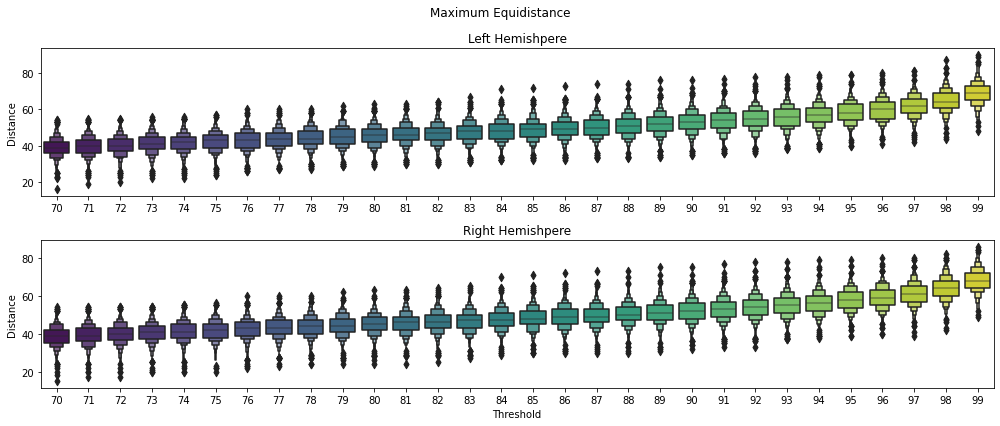

In [43]:
plot_df(Lmaxi,Rmaxi,'Maximum Equidistance')
plt.savefig('dec52022/MaxDist.png',dpi=300,bbox_inches='tight',facecolor='w')

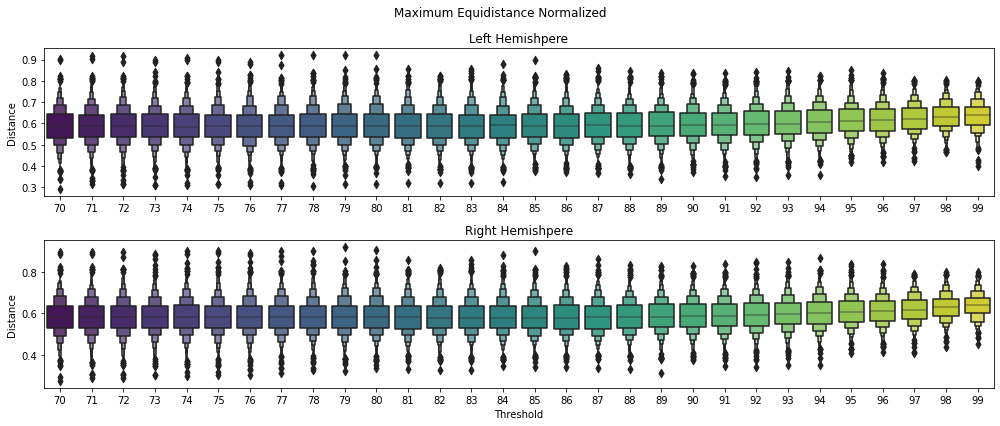

In [44]:
plot_df(LmaxiN,RmaxiN,'Maximum Equidistance Normalized')
plt.savefig('dec52022/MaxDistNorm.png',dpi=300,bbox_inches='tight',facecolor='w')

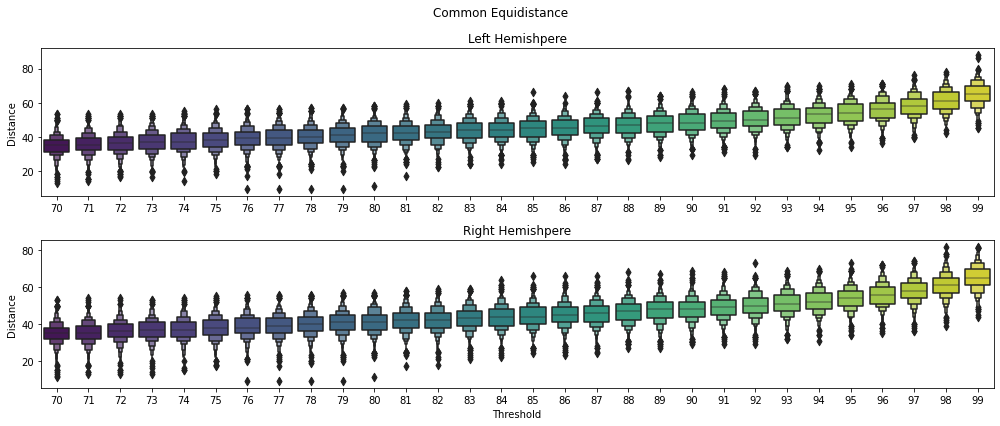

In [45]:
plot_df(Lcommon,Rcommon,'Common Equidistance')
plt.savefig('dec52022/CommonDist.png',dpi=300,bbox_inches='tight',facecolor='w')

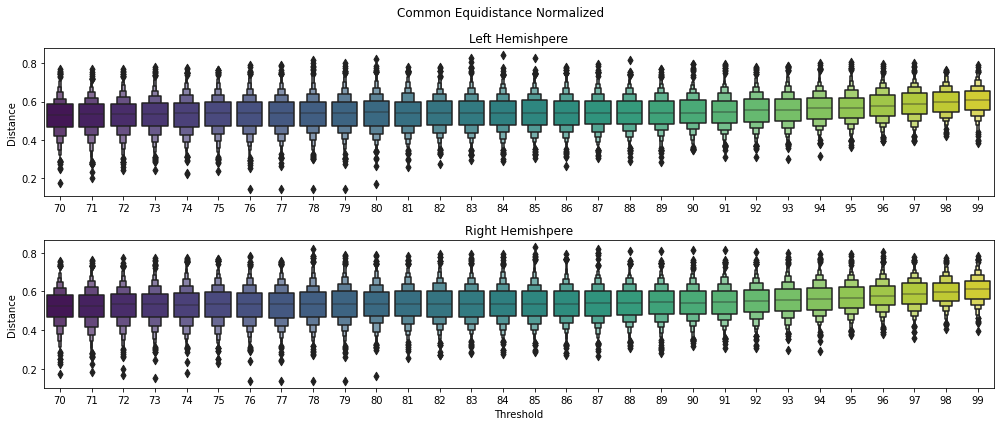

In [46]:
plot_df(LcommonN,RcommonN,'Common Equidistance Normalized')
plt.savefig('dec52022/CommonDistNorm.png',dpi=300,bbox_inches='tight',facecolor='w')

In [47]:
names=['min','minNorm','max','maxNorm','common','commonNorm','globalMax']
L=[Lmini,LminiN,Lmaxi,LmaxiN,Lcommon,LcommonN,Lg]
R=[Rmini,RminiN,Rmaxi,RmaxiN,Rcommon,RcommonN,Rg]

In [48]:
for i in range(len(L)):
    L[i].describe().to_csv(f'dec52022/L.{names[i]}.csv')
    R[i].describe().to_csv(f'dec52022/R.{names[i]}.csv')

In [49]:
Lmini.describe().to_csv('dec52022/test.csv')

In [50]:
left={}
right={}
for i in range(len(L)):
    left[names[i]]=L[i].std()/L[i].mean()
    right[names[i]]=R[i].std()/R[i].mean()

In [58]:
a=pd.DataFrame.from_dict(right).T

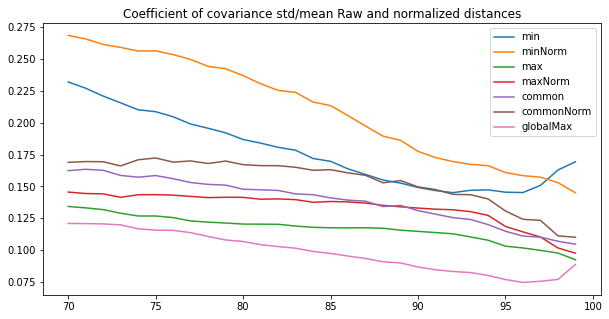

In [59]:
a.T.plot(figsize=(10,5))
plt.title('Coefficient of covariance std/mean Raw and normalized distances')
plt.savefig('dec52022/R.cofofVarAll.png',dpi=300,bbox_inches='tight',facecolor='w')

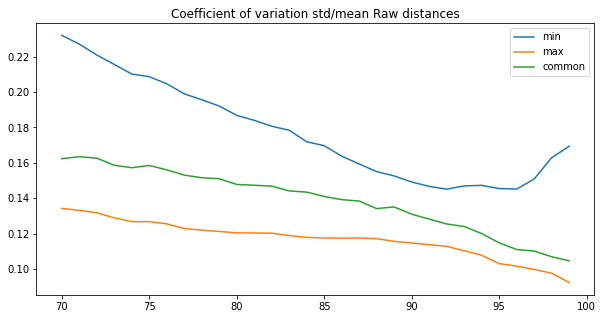

In [60]:
a.T[['min','max','common']].plot(figsize=(10,5))
plt.title('Coefficient of variation std/mean Raw distances')
plt.savefig('dec52022/R.cofofVarRaw.png',dpi=300,bbox_inches='tight',facecolor='w')

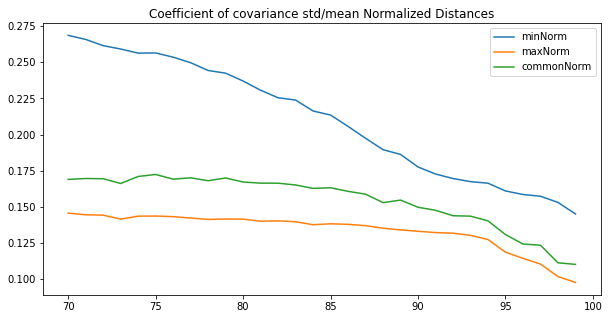

In [61]:
a.T[['minNorm','maxNorm','commonNorm']].plot(figsize=(10,5))
plt.title('Coefficient of covariance std/mean Normalized Distances')
plt.savefig('dec52022/R.cofofVarNorm.png',dpi=300,bbox_inches='tight',facecolor='w')